# Gorgo probablistic programming language

🚧 This project is a work in progress 🚧

Gorgo is a lightweight probabilistic programming language for cognitive modeling
that is written entirely in Python. It prioritizes ease of use, universality, 
and maintainability. It takes inspiration from the design and implementation
of [WebPPL](https://dippl.org/).  

## Getting started

### Using a virtual environment
- Set up a [virtual environment](https://docs.python.org/3/library/venv.html)
- In the virtual environment, run: `pip install git+https://github.com/markkho/gorgo.git`


## Examples

### Simple discrete variables

In [1]:
from gorgo import infer, condition, flip

@infer
def model(p):
    x = flip(p)
    y = flip(p)
    condition(x >= y)
    return x + y

In [2]:
model(0.5)

,Element,Probability
0,0,0.333
1,1,0.333
2,2,0.333


In [3]:
model(.7)

,Element,Probability
0,2,0.620
1,1,0.266
2,0,0.114


### Medical Diagnosis Example

In [4]:
@infer
def model():
    smokes = flip(.2)
    lungDisease = flip(0.001) or (smokes and flip(0.1))
    cold = flip(0.02)
    
    cough = (cold and flip(0.5)) or (lungDisease and flip(0.5)) or flip(0.001)
    fever = (cold and flip(0.3)) or flip(0.01)
    chestPain = (lungDisease and flip(0.2)) or flip(0.01)
    shortnessOfBreath = (lungDisease and flip(0.2)) or flip(0.01)

    condition(cough and chestPain and shortnessOfBreath)

    return {'smokes': smokes}

model()

smokes,Probability
True,0.960
False,0.040


### Recursive distributions

<Axes: ylabel='Probability'>

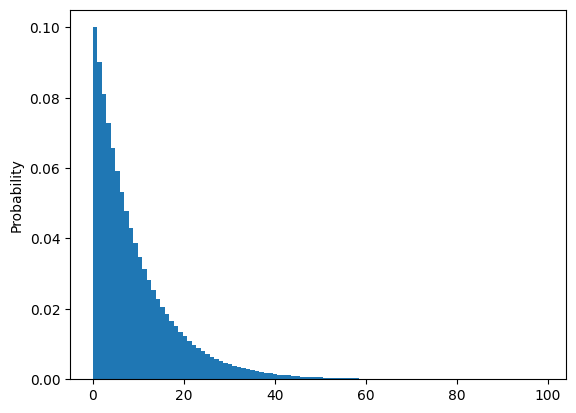

In [5]:
@infer(
    max_states=100,
    _emit_call_entryexit=False # temporary fix for a bug
)
def geometric(p):
    if flip(p):
        return 1 + geometric(p)
    return 0
res = geometric(.9)
res.plot()

<Axes: ylabel='Probability'>

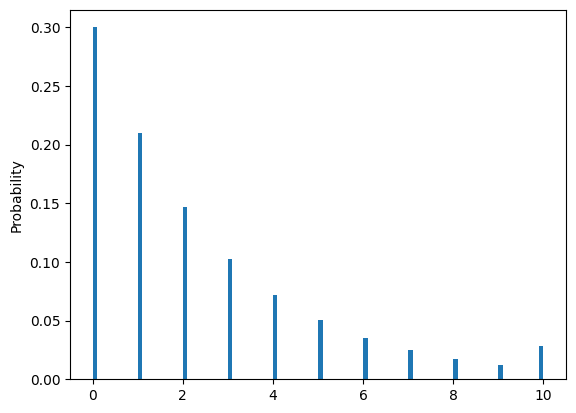

In [6]:
@infer
def truncated_geometric(p, n):
    if n == 0:
        return 0
    if flip(p):
        return 1 + truncated_geometric(p, n - 1)
    return 0
truncated_geometric(.7, 10).plot()

### Continuous Distributions

<Axes: ylabel='Probability'>

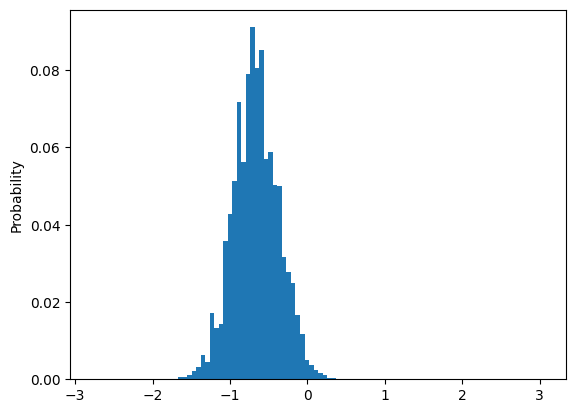

In [7]:
from gorgo.distributions import Normal

@infer(
    method="LikelihoodWeighting",
    samples=1000,
    seed=1234
)
def normal_model(obs, hyper_mu, hyper_sigma, sigma):
    mu = Normal(hyper_mu, hyper_sigma).sample()
    [Normal(mu, sigma).observe(o) for o in obs]
    return mu

obs = (-.75, -.72, -.57, -.82, -.69, -.77, -.74, -.76, -.8, -.79)
res = normal_model(obs, hyper_mu=0, hyper_sigma=1, sigma=1)
res.plot()

In [7]:
from gorgo.distributions import Uniform

@infer(
    method="MetropolisHastings",
    samples=500,
    burn_in=500,
    thinning=5,
    seed=1234
)
def mixture_model(data):
    p = Uniform(0, 1).sample()
    mu1 = Normal(0, 5).sample()
    mu2 = Normal(0, 5).sample()
    cluster = [flip(p) for _ in data]
    [
        Normal(mu1, 1).observe(data[i]) if cluster[i] else Normal(mu2, 1).observe(data[i])
        for i in range(len(data))
    ]
    return dict(p=p, mu1=mu1, mu2=mu2)
    # return cluster

<Axes: ylabel='Probability'>

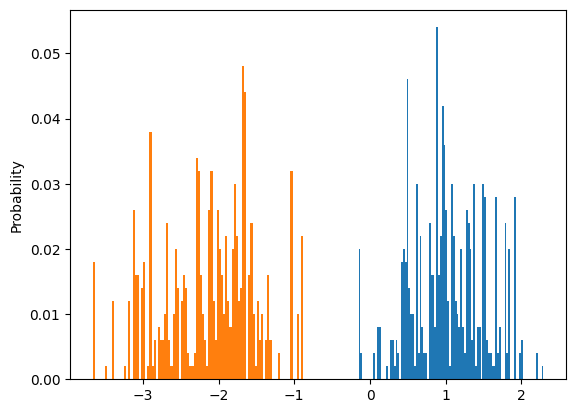

In [8]:
import matplotlib.pyplot as plt

data = (
    -3.39, -0.74, -1.74, -3.84, -1.87,  # cluster 1; mu1 = -2, sigma1 = 1
    0.12, 1.18, -0.32, 1.3, 2.26 # cluster 2; mu2 = 1, sigma2 = 1
)
res = mixture_model(data)

fig, ax = plt.subplots()
res.marginalize(lambda x: x["mu1"]).plot(ax)
res.marginalize(lambda x: x["mu2"]).plot(ax)

To create this README file, run:
```
jupyter nbconvert --execute --to markdown README.ipynb
```